# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 11/07/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\12188\OneDrive - Cornell University\BEE 4750\homework\hw04`


In [3]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 50/60 Points)

### Problem 1 (20 points)

A farmer has access to a pesticide which can be used on corn, soybeans,
and wheat fields, and costs \$70/kg-yr to apply. The crop yields the
farmer can obtain following crop yields by applying varying rates of
pesticides to the field are shown in
<a href="#tbl-yields" class="quarto-xref">Table 1</a>.

| Application Rate (kg/ha) | Soybean (kg/ha) | Wheat (kg/ha) | Corn (kg/ha) |
|:------------------------:|:---------------:|:-------------:|:------------:|
|            0             |      2900       |     3500      |     5900     |
|            1             |      3800       |     4100      |     6700     |
|            2             |      4400       |     4200      |     7900     |

Table 1: Crop yields from applying varying pesticide rates for Problem
1.

The costs of production, *excluding pesticides*, for each crop, and
selling prices, are shown in
<a href="#tbl-costs" class="quarto-xref">Table 2</a>.

|   Crop   | Production Cost (\$/ha-yr) | Selling Price (\$/kg) |
|:--------:|:--------------------------:|:---------------------:|
| Soybeans |            350             |         0.36          |
|  Wheat   |            280             |         0.27          |
|   Corn   |            390             |         0.22          |

Table 2: Costs of crop production, excluding pesticides, and selling
prices for each crop.

Recently, environmental authorities have declared that farms cannot have
an *average* application rate on soybeans, wheat, and corn which exceeds
0.8, 0.7, and 0.6 kg/ha, respectively. The farmer has asked you for
advice on how they should plant crops and apply pesticides to maximize
profits over 130 total ha while remaining in regulatory compliance if
demand for each crop (which is the maximum the market would buy) this
year is 250,000 kg?

**In this problem**:

-   Formulate a linear program for this resource allocation problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations). **Tip: Make sure that all of your constraints are
    linear**.
-   Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?
-   The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.

Decision Variables: <br>
hectares of soybeans at pesticide application rates 0, 1, and 2 kg/ha <br>
hectares of wheat at pesticide application rates 0, 1, and 2 kg/ha <br>
hectares of corn at pesticide application rates 0, 1, and 2 kg/ha <br>
Objective Function: <br>
Goal is to maximize total profit across all crops <br>
Max Profit = sum crop yields in kg * selling price by kg - sum hectares planted by crop * production cost per hectare of each crop - total pesticide application in kg * pesticide cost per kg <br>
Constraints: <br>
Mean Pesticide Application Rate for each crop: <br>
(0 * 0kg/ha rate crop hectares) + (1 * 1kg/ha rate crop hectares) + (2 * 2kg/ha rate crop hectares) / hectares of crop production <= Regulation
where regulation is 0.8, 0.7, and 0.6 kg/ha for soybeans, wheat, and corn respectively <br>
can move the denominator to opposite side of inequality to ensure linearity <br>
Area: <br>
sum of all hecatres planted cannot be greater than 130 hectares <br>
Demand: <br>
production in kg for each crop cannot be greater than 250,000 kg


In [ ]:
# model crops maximizes profit by optimizing hectares dedicated to each crop and pesticide application rate with constraints
# on demand, total area, and pesticide application rates
crops = Model(HiGHS.Optimizer)
# hectares dedicated to each cropping system cannot be below zero
@variable(crops, 0 <= S0)
@variable(crops, 0 <= S1)
@variable(crops, 0 <= S2)
@variable(crops, 0 <= W0)
@variable(crops, 0 <= W1)
@variable(crops, 0 <= W2)
@variable(crops, 0 <= C0)
@variable(crops, 0 <= C1)
@variable(crops, 0 <= C2)
# maximizing profit (revenue - costs)
@objective(crops, Max, (S0*2900 + S1*3800 + S2*4400)*.36 + (W0*3500 + W1*4100 + W2*4200)*.27 
+ (C0*5900 + C1*6700 + C2*7900)*.22 
- (S0+S1+S2)*350 - (W0+W1+W2)*280 - (C0+C1+C2)*390 - ((S1+W1+C1)+ 2*(S2+W2+C2))*70) 
# constraining based on hectares available
@constraint(crops, area, S0 + S1 + S2 + W0 + W1 + W2 + C0 + C1 + C2 <= 130)
# constraining based on max pesticide application rate for each crop
@constraint(crops, SPA, (S1 + 2*S2) <= 0.8*(S0+S1+S2))
@constraint(crops, WPA, (W1 + 2*W2) <= 0.7*(W0+W1+W2))
@constraint(crops, CPA, (C1 + 2*C2) <= 0.6*(C0+C1+C2))
# constraining based on demand for each crop
@constraint(crops, SD, (S0*2900 + S1*3800 + S2*4400) <= 250000)
@constraint(crops, WD, (W0*3500 + W1*4100 + W2*4200) <= 250000)
@constraint(crops, CD, (C0*5900 + C1*6700 + C2*7900) <= 250000)
# optimizing
optimize!(crops)
# show optimized hectares of each crop by pesticide application rate
@show value(S0)
@show value(S1)
@show value(S2)
@show value(W0)
@show value(W1)
@show value(W2)
@show value(C0)
@show value(C1)
@show value(C2)
# show optimized profits
@show objective_value(crops)
# show shadow price of additional hectare of land
@show shadow_price(area)
# show optimized pesticide application rates
@expression(crops, SoyPA, (S1 + 2*S2) / (S0+S1+S2))
@expression(crops, WhPA, (W1 + 2*W2) / (W0+W1+W2))
@expression(crops, CoPA, (C1 + 2*C2) / (C0+C1+C2))
@show value(SoyPA)
@show value(WhPA)
@show value(CoPA)
# show total mass of each crop produced
@expression(crops,SDM, (S0*2900 + S1*3800 + S2*4400))
@show value(SDM)
@expression(crops,WDM, (W0*3500 + W1*4100 + W2*4200))
@show value(WDM)
@expression(crops,CDM, (C0*5900 + C1*6700 + C2*7900))
@show value(CDM)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [7e+02, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.8170297740e+02 Ph1: 7(28.3601); Du: 9(181.703) 0s
          7     1.1674116702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.1674116702e+05
HiGHS run time      :          0.01
value(S0) = 13.812154696132593
value(S1) = 55.24861878453038
value(S2) = 0.0
value(W0) = 6.743306417339564
value(W1) = 15.73438164045898
value(W2) = 0.0
value(C0) = 26.923076923076927
value(C1) = 0.0
value(C2) = 11.538461538461554
objective_va

250000.00000000015

The 130 hectares should be partitioned:<br>
Untreated Soybean: 13.81 ha <br>
1kg/ha Soybean: 55.25 ha <br>
2kg/ha Soybean: 0 <br>
Untreated Wheat: 6.74 ha <br>
1kg/ha Wheat: 15.73 ha <br>
2kg/ha Wheat: 0 <br>
Untreated Corn: 26.92 ha <br>
1kg/ha Corn: 0 <br>
2kg/ha Corn: 11.54 ha <br>

All crops are treated on average at their maximum pesticide application rates: 0.8 kg/ha, 0.7 kg/ha, 0.6 kg/ha for soybean, wheat, and corn respectively. The expected profit under the optimal regiment is $116,741. Using the shadow price for the area constraint, 10 extra hectares would increase profits by $7294. This makes sense as soybean and corn production is already at the level of demand, so the ten extra hectares would be wheat planted at an average pesticide treatment of 0.7 kg/ha which generates a profit equal to that of the shadow price per hectare. If the increased labor is not a concern I would recommend the purchase of the additional ten hectares as it increases profits by a not insignificant amount. 

### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

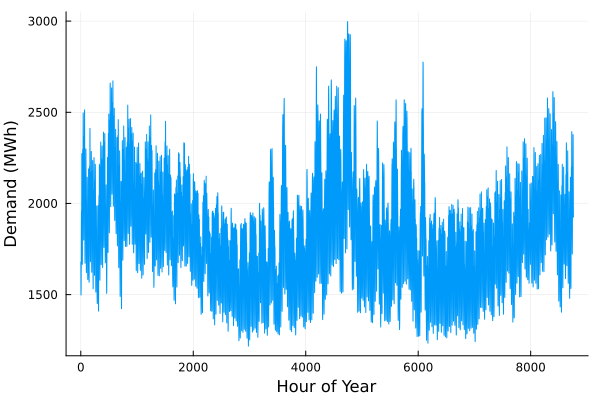

In [5]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [6]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

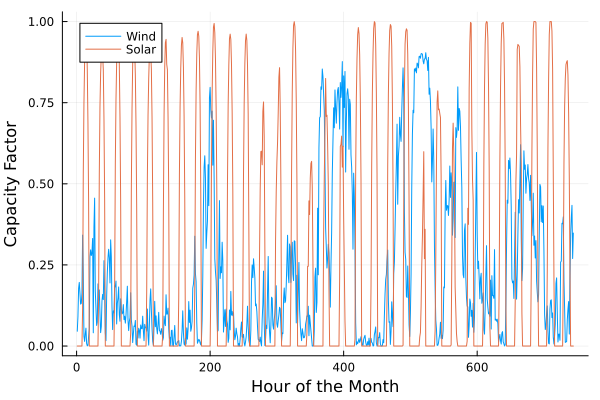

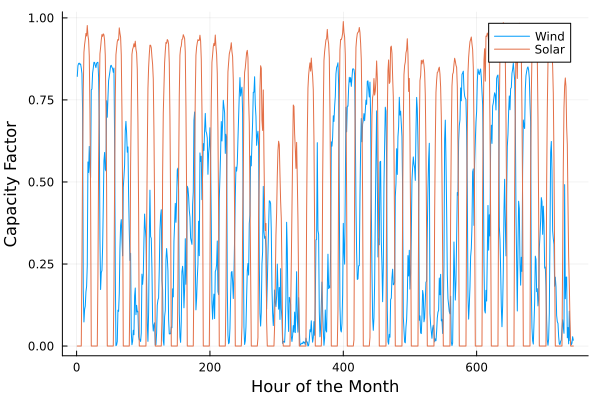

In [7]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))
# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

Available Energy Sources: <br>
Geothermal, Coal, NG CCGT, NG CT, Wind, Solar <br>
Decision Variables: <br>
x array: installed capacity of each energy source (MW) <br>
y array: hourly production of each energy source (MWh) <br>
NSE: hourly non-served energy (MWh) <br>
Objective Function: <br>
Goal is to minimize total cost of installation, variable costs, and the NSE cost penalty <br>
min Z = sum of fixed costs over all x + sum variable costs over all x and t + sum NSE cost over all t
Constraints: <br>
load: the sum of hourly energy production over all x generation sources and non-served energy must by at least equal to the hourly energy demand <br>
availability: the hourly energy produced cannot be greater than the energy installed across all generation sources <br>
capacity: the hourly energy produced cannot be greater than the energy installed across all generation sources scaled by their capacity factor at each hour <br>

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [5e-05, 1e+00]
  Cost   [2e+01, 4e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+03, 3e+03]
Presolving model
109416 rows, 56862 cols, 253704 nonzeros  0s
78640 rows, 56862 cols, 196616 nonzeros  0s
78640 rows, 56862 cols, 196616 nonzeros  0s
Presolve : Reductions: rows 78640(-35240); columns 56862(-4464); elements 196616(-70480)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(2.14949e+06) 0s
      42364     6.5405658346e+08 Pr: 664(5885.28); Du: 0(3.36847e-06) 5s
      43093     6.5458487038e+08 Pr: 0(0); Du: 0(2.90714e-10) 6s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 43093
Objective value     :  6.5458487038e+08
HiGHS run time      :          6.08
objective_value(gencap) = 6.545848703815941

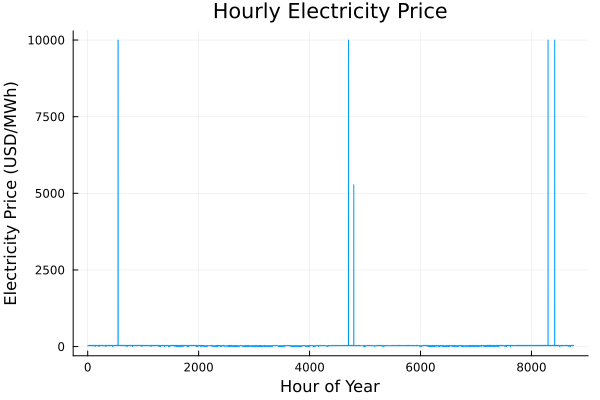

In [ ]:
# define sets
G = 1:nrow(gens[:, :])
T = 1:nrow(demand)
# create capacity factor matrix
c = ones(6,8760)
c[1,:] = c[1,:]*.85
c[5,:] = cap_factor[:,2]
c[6,:] = cap_factor[:,3]
# define NSE cost penalty
NSECost = 10000

# model gencap minimizes total cost of energy system
gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    x[g in G] >= 0
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end);
# objective total cost function to be minimized
@objective(gencap, Min, 
    sum(gens[G, :FixedCost] .* x) + sum(gens[G, :VarCost] .* 
    sum(y[:, t] for t in T)) + NSECost * sum(NSE)
);
# constraints on load demand, availability of installed sources, and capacity of installed sources
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= demand.Demand[t]);
@constraint(gencap, availability[g in G, t in T], y[g, t] <= x[g]);
@constraint(gencap, capacity[g in G, t in T], 
    y[g,t] <= x[g] * c[g,t]);
optimize!(gencap)
# show total minimized cost
@show objective_value(gencap)
# show installation sources result
rounded_x = round.(value.(x), sigdigits=3) 
@show rounded_x

# calculate total cost of construction
totalcost = sum(gens[G, :FixedCost] .* value.(x))

# calculate total non-served energy
totalnse = sum(value.(NSE[t]) for t in T)

@show round(totalcost, sigdigits=3)
@show round(totalnse, sigdigits=3)  

# find production ratios
ys = value.(y)
total_g = sum(ys);
prNGCCGT = sum(ys[3,:])/total_g;
prNGCT = sum(ys[4,:])/total_g;
prwind = sum(ys[5,:])/total_g;
prsolar = sum(ys[6,:])/total_g;
@show value(prNGCCGT)
@show value(prNGCT)
@show value(prwind)
@show value(prsolar)

# find installation ratios
xs = value.(x)
total_i = sum(xs);
irNGCCGT = xs[3]/total_i;
irNGCT = xs[4]/total_i;
irwind = xs[5]/total_i;
irsolar = xs[6]/total_i;
@show value(irNGCCGT)
@show value(irNGCT)
@show value(irwind)
@show value(irsolar)

# find and plot hourly energy cost
hrprice = abs.([shadow_price(load[t]) for t in T])

plot(T,hrprice,xlabel="Hour of Year",ylabel="Electricity Price (USD/MWh)",
title="Hourly Electricity Price",legend=false)

Optimized Installation: <br>
Geothermal: 0 <br>
Coal: 0 <br>
NG CCGT: 1660 MW <br>
NG CT: 880 MW <br>
Wind: 485 MW <br>
Solar: 1960 MW <br>

Total Cost of Construction: $3.74 x 10^8 <br>
Optimal Total Cost of System (Total+Variable+NSE): $6.55 x 10^8 <br>
Non-served Energy: 257 MWh <br>

Breakdown of Annual Production: <br>
Geothermal: 0 <br>
Coal: 0 <br>
NG CCGT: 0.529 <br>
NG CT: 0.027 <br>
Wind: 0.086 <br>
Solar: 0.358 <br>

Breakdown of Installed Capacity: <br>
Geothermal: 0 <br>
Coal: 0 <br>
NG CCGT: 0.333 <br>
NG CT: 0.177 <br>
Wind: 0.097 <br>
Solar: 0.393 <br>

The ratio of production for NG CCGT is higher than the ratio of its installation compared to other energy sources. All other energy sources have a higher ratio of installation than production. NG CT has the lowest ratio of production as compared to installation. NGCT is disadvantaged due to its high variable cost while the renewables are disadvantaged by their capacity factors.<br>

The hourly trends in the electricity price plot are overshadowed by the large effect of the non-served energy cost penaltities which occur during sudden large amplitude spikes in energy demand. 

